In [1]:
import os
import sys
import random
import warnings
import cv2
import time
import numpy as np

import matplotlib.pyplot as plt
import glob
from tqdm import tqdm          
import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.preprocessing.image import array_to_img
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
## ¨Ï¥ÎGPU
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
##################### 用來將檔案內的 Image 或 Mask 寫入 TXT 檔案，會將 Image & Mask 做對應   ##########################
## ImagePath : 圖片全路徑
## MaskPath : 遮罩資料夾路徑
## saveName : 要存的 TXT 名稱
## typeMask : 遮罩圖片的副檔名           
def txtWriter(ImagePath, MaskPath, saveName, typeMask='.jpg'):
    with open(saveName + '.txt', 'w') as f:
        for name in ImagePath:
            fileName = os.path.splitext(name)[0]
            fileName = fileName.split('/')[-1]
            f.write(name + ' ' + MaskPath + fileName + typeMask + '\n')


In [3]:
import os
import glob
ImagePath = glob.glob('./A/*.jpg')
txtWriter(ImagePath,'./AA/', 'AAA')

In [4]:
############################## 多筆資料要做訓練時，藉由此函式讀取資料並搭配 keras 的 fit_generate ##############################
## 隨機生成 Image & Mask
## txtFile : TXT 檔案路徑
## batch_size : batch 大小
## IMAGW_WIDTH : 圖片寬度
## IMAGW_HEIGHT : 圖片高度
def generate_data(txtFile, batch_size, IMAGE_WIDTH, IMAGE_HEIGHT):
    """Replaces Keras' native ImageDataGenerator."""
    f = open(txtFile, 'r')
    items = f.readlines()
    i = 0
    while True:
#         image_batch = []
#         label_batch = []
        image_batch = np.zeros((batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype=np.float32)
        label_batch = np.zeros((batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.bool)
        for b in range(batch_size):
            mask = np.zeros((IMAGE_WIDTH, IMAGE_HEIGHT, 1), dtype=np.bool)
            if i == len(items)//batch_size:
                i = 0
                random.shuffle(items)
            sample = items[i]
            image_path = sample.split(' ')[0]                   ## 以空白部分分開兩段  [xxx xxx]
            label_path = sample.split(' ')[-1].strip()          ## 去掉後面 \n
            #### 圖片處理
            image = cv2.resize(cv2.imread(image_path), (IMAGE_WIDTH, IMAGE_HEIGHT), 
                               interpolation=cv2.INTER_CUBIC)
            image_batch[b] = image.astype(np.float32) / 255.0
            ### 遮罩處理
            label = cv2.imread(label_path)
            label = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
            label = cv2.resize(label,(IMAGE_WIDTH,IMAGE_HEIGHT), interpolation=cv2.INTER_CUBIC)
#             b, label = cv2.threshold(label, 0, 255, cv2.THRESH_BINARY)   ## 進行二值化，使目標物變成白色
#             label = label.astype(np.float32) / 255.0
            label = np.expand_dims(label, axis=-1)
            mask = np.maximum(mask, label)
            label_batch[b] = mask
            i += 1
        yield image_batch, label_batch


In [5]:
import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.preprocessing.image import array_to_img
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import numpy as np

# Set some parameters
IMG_WIDTH =  768
IMG_HEIGHT = 768

IMG_WIDTH2 =  256
IMG_HEIGHT2 = 256

IMG_CHANNELS = 3

# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def UnetModel(pretrained_model = None, input_size = (IMG_WIDTH2, IMG_HEIGHT2, 3)):
    "This is a UnetModel-RGB to Remvoe Background"
    inputs = Input(input_size)

    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6])
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7])

    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8])

    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9])
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)


    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)

    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=[mean_iou])
    
    if(pretrained_model):
        model = load_model(pretrained_model)
    
    model.summary()
    return model
	
def RGB_UnetModel(pretrained_model = None, input_size = (IMG_WIDTH2, IMG_HEIGHT2, 3)):
    "This is a UnetModel-RGB to Remvoe Background"
    inputs = Input(input_size)

    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal', dilation_rate=(2, 2))(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal', dilation_rate=(2, 2))(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6])
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    conv6 = BatchNormalization()(conv6)
    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7])

    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    conv7 = BatchNormalization()(conv7)
    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8])

    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9])
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)


    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)

    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=[mean_iou])
    
    if(pretrained_model):
        model.load_model(pretrained_model)
    
    model.summary()
    return model



def Simplify_UnetModel(pretrained_model = None, input_size = (IMG_WIDTH2, IMG_HEIGHT2, 3)):
    "This is a UnetModel-RGB to Remvoe Background"
    
    inputs = Input(input_size)
    conv0 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv0 = BatchNormalization()(conv0)
    conv0 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv0)
    conv0 = BatchNormalization()(conv0)
    comp0 = AveragePooling2D((6,6))(conv0)

    conv1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(comp0)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Dropout(0.4)(conv1)

    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
    conv2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Dropout(0.4)(conv2)

    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
    conv3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Dropout(0.4)(conv3)

    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
    conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Dropout(0.4)(conv4)

    pool4 = MaxPooling2D(pool_size=(2,2))(conv4)
    conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)

    upcv6 = UpSampling2D(size=(2,2))(conv5)
    upcv6 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv6)
    upcv6 = BatchNormalization()(upcv6)
    mrge6 = concatenate([conv4, upcv6], axis=3)
    conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    conv6 = BatchNormalization()(conv6)

    upcv7 = UpSampling2D(size=(2,2))(conv6)
    upcv7 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv7)
    upcv7 = BatchNormalization()(upcv7)
    mrge7 = concatenate([conv3, upcv7], axis=3)
    conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    conv7 = BatchNormalization()(conv7)

    upcv8 = UpSampling2D(size=(2,2))(conv7)
    upcv8 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv8)
    upcv8 = BatchNormalization()(upcv8)
    mrge8 = concatenate([conv2, upcv8], axis=3)
    conv8 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)

    upcv9 = UpSampling2D(size=(2,2))(conv8)
    upcv9 = Conv2D(16, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv9)
    upcv9 = BatchNormalization()(upcv9)
    mrge9 = concatenate([conv1, upcv9], axis=3)
    conv9 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)

    dcmp10 = UpSampling2D((6,6), interpolation='bilinear')(conv9)
    mrge10 = concatenate([dcmp10, conv0], axis=3)
    conv10 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge10)
    conv10 = BatchNormalization()(conv10)
    conv10 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv10)
    conv10 = BatchNormalization()(conv10)
    conv11 = Conv2D(1, 1, activation='sigmoid')(conv10)

    model = Model(inputs=inputs, outputs=conv11)
    
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=[mean_iou])
    
    if(pretrained_model):
        model.load_model(pretrained_model)
        
    model.summary()
    return model

In [ ]:
import cv2
import random 

train = generate_data('./AAA.txt', 2, 768, 768)
# val = generate_data('./Test.txt', 16, IMG_WIDTH, IMG_HEIGHT)

# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('./ship_model/unet_nodatagen2.h5', monitor='loss', verbose=1, save_best_only=True)

# results = model.fit(trainX, trainY, validation_split=0.2, batch_size=2, epochs=50, 
#                     callbacks=[checkpointer], verbose=1, shuffle=True)

# results = model.fit(X_train_part, Y_train_part, validation_data=(X_test_part, Y_test_part), batch_size=32, epochs=50, 
#                     callbacks=[checkpointer], verbose=1, shuffle=True)
model = Simplify_UnetModel()
result = model.fit_generator(train,
                        steps_per_epoch=  28980//2,
#                         validation_data=val,
#                         validation_steps=5000 // 16,
                        epochs=50,
                        callbacks=[checkpointer])

In [ ]:
fig = plt.figure(figsize=(15,10), dpi=300)
plt.plot(result.history['mean_iou'])
plt.plot(result.history['loss'])
plt.legend(['mean_iou', 'loss'], fontsize=18)
plt.xlabel('epochs')
plt.ylabel('percent')
plt.title('U-net', fontsize=15)
plt.savefig('./ship_model/1.png')

In [6]:
from numpy import shape
def stack(imgPath, labelPath, model, imageheight, imageweight):
    imgOrg = cv2.imread(imgPath)
    width, height = imgOrg.shape[:2]
    img = cv2.resize(imgOrg, (imageheight, imageweight))
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)
    mask = model.predict(img)
    mask = (mask > 0.5).astype(np.uint8)        
    mask = np.squeeze(mask) 
    mask = cv2.resize(mask, (height, width), interpolation=cv2.INTER_CUBIC)
    b,g,r = cv2.split(imgOrg)       # get b,g,r
    imgOrg = cv2.merge([r,g,b])     # switch it to rgb
    remove = cv2.bitwise_and(imgOrg, imgOrg, mask= mask)
    for a in range(768):
        for b in range(768):
            if(mask[a,b]>0):
                mask[a,b]=255
    img_pred=cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    
    B,G,R = cv2.split(img_pred)
    for a in range(768):
        for b in range(768):
            if(R[a,b]>0):
                R[a,b]= 176
    for a in range(768):
        for b in range(768):
            if(G[a,b]>0):
                G[a,b]= 23          
    for a in range(768):
        for b in range(768):
            if(B[a,b]>0):
                B[a,b]= 31       
    predict = cv2.merge([R,G,B])  
    #predict = predict[:,:,[2,1,0]]
    #cv2.imwrite('./ship_model/2.jpg',predict)
    
    img_label = cv2.imread(labelPath)
    #label_RGB=cv2.cvtColor(imglabel, cv2.COLOR_GRAY2BGR)
    B,G,R = cv2.split(img_label)
    for a in range(768):
        for b in range(768):
            if(R[a,b]>254):
                R[a,b]= 0
    for a in range(768):
        for b in range(768):
            if(G[a,b]>254):
                G[a,b]= 255         
    for a in range(768):
        for b in range(768):
            if(B[a,b]>254):
                B[a,b]= 255
    label = cv2.merge([R,G,B])  
    #label = label[:,:,[2,1,0]]
    #cv2.imwrite('./ship_model/3.jpg',label)
  
    B,G,R = cv2.split(imgOrg)
    for a in range(768):
        for b in range(768):
            for c in range(3): 
                if ((img_label[a, b, c]>=250) and (img_pred[a, b, c]!=255)):
                    R[a,b] = 0
                    G[a,b] = 255
                    B[a,b] = 255
    for a in range(768):
        for b in range(768):
            for c in range(3):            
                if((img_label[a, b, c] >0) and (img_pred[a, b, c] >0) and (img_pred[a, b, c]==255) and (img_label[a, b, c]!=255)):
                    R[a,b] = 176
                    G[a,b] = 23
                    B[a,b] = 31
    for a in range(768):
        for b in range(768):
            for c in range(3):
                if((img_label[a, b, c] >0) and (img_pred[a, b, c] >0) and (img_label[a, b, c] == img_pred[a, b, c])):
                    R[a,b] = 124
                    G[a,b] = 252
                    B[a,b] = 0
    pred_AND_label = cv2.merge([R,G,B])  
    #pred_AND_label = pred_AND_label[:,:,[2,1,0]]
    cv2.imwrite('./ship_model/4.jpg',pred_AND_label)
    plt.figure(figsize=(15,15))
    plt.subplot(131)
    plt.grid(False)
    plt.imshow(label)
    plt.subplot(132)
    plt.grid(False)
    plt.imshow(predict)
    plt.subplot(133)
    plt.grid(False)
    plt.imshow(pred_AND_label)
    

def removebackground(imgPath, path, model, imageheight, imageweight):
    imgOrg = cv2.imread(imgPath)
    width, height = imgOrg.shape[:2]
    img = cv2.resize(imgOrg, (imageheight, imageweight))
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)
    mask = cv2.imread(path)
    #mask = model.predict(img)
    #mask = (mask > 0.5).astype(np.uint8)                   
    #mask = np.squeeze(mask)                                 
    mask = cv2.resize(mask, (height, width), interpolation=cv2.INTER_CUBIC)
    b,g,r = cv2.split(imgOrg)       # get b,g,r
    imgOrg = cv2.merge([r,g,b])     # switch it to rgb
    remove = cv2.bitwise_and(imgOrg, imgOrg, mask= mask)
    plt.figure(figsize=(15,15))
    plt.subplot(121)
    plt.grid(False)
    plt.imshow(imgOrg)
    plt.subplot(122)
    plt.grid(False)
    plt.imshow(remove)

In [7]:
#model = load_model('/home/user/Desktop/airbus-ship-detection/model-unet1.h5')
model = load_model('./ship_model/unet_nodatagen.h5', custom_objects={'mean_iou': mean_iou})

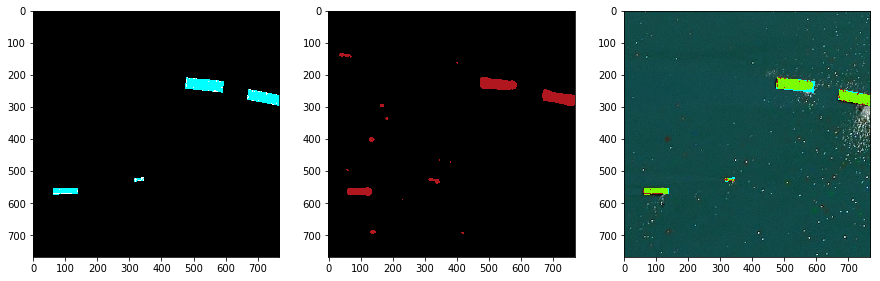

In [8]:
#for i in range(2):
#    stack('./test/%d.jpg' % (i),'./test/mask_%d.jpg' % (i), model, 768, 768)
stack('./A/0.jpg','./AA/0.jpg' , model, 768, 768)

In [ ]:
def load_data(imgPath, maskFolder, IMAGE_HEIGHT, IMAGE_WIDTH):
    print('Getting and resizing image & masks ...')
    sys.stdout.flush()
    
    image_batch = np.zeros((len(imgPath), IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype=np.float16)
    label_batch = np.zeros((len(imgPath), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.bool)
    
    for i, trainPath in tqdm(enumerate(imgPath), total=len(imgPath)):
        mask = np.zeros((IMAGE_WIDTH, IMAGE_HEIGHT, 1), dtype=np.bool)
        image = cv2.resize(cv2.imread(trainPath), (IMAGE_WIDTH, IMAGE_HEIGHT), 
                           interpolation=cv2.INTER_CUBIC)
        image_batch[i] = image.astype(np.float32) / 255.0
        
        labelPath = os.path.splitext(trainPath)[0]
        labelPath = maskFolder + labelPath.split('/')[-1] + '.jpg'
        
        label = cv2.imread(labelPath)
        label = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
        label = cv2.resize(label,(IMAGE_WIDTH,IMAGE_HEIGHT), interpolation=cv2.INTER_CUBIC)
        b, label = cv2.threshold(label, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)  
        label = np.expand_dims(label, axis=-1)
        mask = np.maximum(mask, label)
        label_batch[i] = mask
    print(image_batch.shape, label_batch.shape)
    return image_batch, label_batch

## Different data 
PreTrainPath = glob.glob('./A/*.jpg')
PreMaskPath = './AA/'
preTrain, preMask = load_data(PreTrainPath, PreMaskPath, 256, 256)
print(preTrain.shape)
print(preMask.shape)

In [ ]:
from keras.preprocessing import image
seed = 40
# Creating the training Image and Mask generator
image_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, 
                                         zoom_range=0.2, width_shift_range=0.2, 
                                         height_shift_range=0.2, fill_mode='reflect')
mask_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, 
                                        zoom_range=0.2, width_shift_range=0.2, 
                                        height_shift_range=0.2, fill_mode='reflect')

# Keep the same seed for image and mask generators so they fit together

image_datagen.fit(preTrain, augment=True, seed=seed)
mask_datagen.fit(preMask, augment=True, seed=seed)
x = image_datagen.flow(preTrain, batch_size=5, shuffle=True, seed=seed)
y = mask_datagen.flow(preMask, batch_size=5, shuffle=True, seed=seed)
train_generator = zip(x, y)

In [ ]:
model = UnetModel()
checkpointer = ModelCheckpoint('./ship_model/unet_have5datagen.h5', monitor='loss', verbose=1, save_best_only=True)
history = model.fit_generator(train_generator,
                        steps_per_epoch=  28980,
#                         validation_data=val,
#                         validation_steps=5000 // 16,
                        epochs=50,
                        callbacks=[checkpointer])

In [9]:
model = load_model('/home/user/ship_model/unet_have5datagen.h5', custom_objects={'mean_iou': mean_iou})

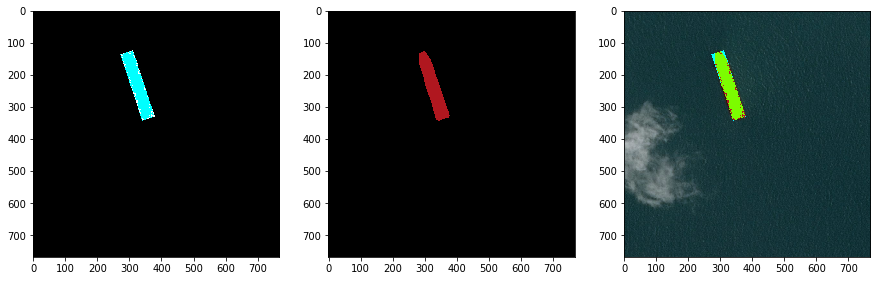

In [10]:
stack('./test/0.jpg','./test/mask_0.jpg', model, 256, 256)

In [ ]:
removebackground('/home/user/test/image/0a8d5d261.jpg', model, 256, 256)